# **YOUNGER - Age Estimator**

# **I. PROBLEM IDENTIFICATION**

## A. Introduction


**[INPUT] → [OUTPUT]**

**[Photo of a face] → [Age estimate]**

**CONTEXT:** "Babyface" a startup skincare company wants to build an app that can estimate a person’s age from an image. They need an app to create an age estimate. The primary problem to solve is: When given a photo of a face, estimate the age with reasonable accuracy. Babyface will eventually use this to create "before & after" age estimates to demonstrate the benefit of their products.

## B. Proposed Method

**i. The techniques** to explore are a combination of **Support Vector Machines, Decision Trees, K Nearest Neighbor, and CNN** (for feature detection).

**ii. Pipeline**

1. DATA WRANGLING - Source Data, Download Data, Explore Data, Clean Data
2. EXPLORATORY DATA ANALYSIS - Statistical EDA, Visual EDA
3. PREPROCESSING - Face Detection, Crop Images, Augmentation
4. TRAINING - Feature Extraction
5. MODELING - Prediction, Hyperparameter Tuning

# **II. DATA WRANGLING**

**DATASET:** [IMDB-WIKI – 500k+ face images with age and gender labels
Rasmus Rothe, Radu Timofte, Luc Van Gool](https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/)
Researchers from ETH Zurich University have created a labeled dataset with success in predicting age and gender from face images.
An image dataset consists of human faces with ages. There are 99 folders where the name of each folder represents the age of the faces inside the folder.

"In total we obtained 460,723 face images from 20,284 celebrities from IMDb and 62,328 from Wikipedia, thus 523,051 in total."

**DETAILS:** The dataset that we will use for our age predictor was created by Rasmus Rothe, Radu Timofte, Luc Van Gool in combination with a competition "ChaLearn LAP 2015" dataset. This dataset was scraped from IMDb and Wikipedia. The dataset is labeled with date-of-birth (DOB) and gender and include only images with timestamps, indicating when the image was captured. The age of the person in the image can be obtained by simply subtracting the person's date of birth from the timestamp date. It is important to note that some of the IMDb dataset images are "production photos" like movie posters and the timestamps may not be precise, since movie production cycles can be months long. S

**APPROACH:** *Download, Explore, Clean:* We will start by downloading the dataset and exploring the images and metadata to understand how to label the data properly with the ages of the subjects. We will then simplify the dataset to exclude varaibles that are unneccessary for our predictor. 

In [1]:
# !pip install tensorflow

In [2]:
### IMPORT ###
### I get by with a little help from my friends ###
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
import requests
import scipy.io
from datetime import datetime, date, time, timedelta
import tensorflow as tf
from tensorflow import keras
import os
from pathlib import Path
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input

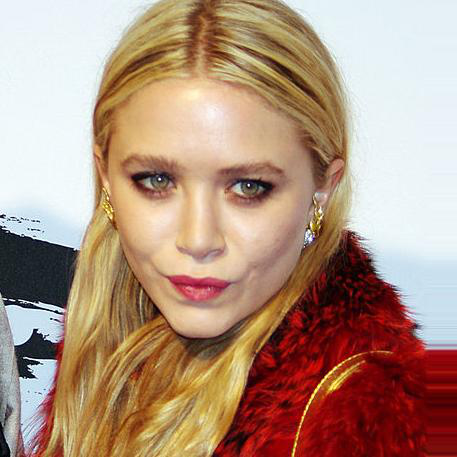

In [3]:
### VIEW AN IMAGE FROM DATASET ###
loc = 'C:/Users/Prem/Desktop/SPRINGBOARD_MASTER/YOUNGER/Data/wiki_crop_subset/81800_1986-06-13_2011.jpg'
image1 = Image.open(loc)
image1

In [4]:
### LOAD METADATA FILE ###
# wiki_mat_path = '/content/drive/MyDrive/YOUNGER/wiki.mat' # COLAB
wiki_mat_path = 'C:/Users/Prem/Desktop/SPRINGBOARD_MASTER/YOUNGER/Data/WIKI_CROP/wiki.mat'

# load .mat as python dict
mat = scipy.io.loadmat(wiki_mat_path)

In [5]:
### EXPLORE METADATA STRUCTURE ###
print(len(mat))
print(len(mat['wiki'][0][0]))
print(mat['wiki'][0][0])

4
8
(array([[723671, 703186, 711677, ..., 720620, 723893, 713846]]), array([[2009, 1964, 2008, ..., 2013, 2011, 2008]], dtype=uint16), array([[array(['17/10000217_1981-05-05_2009.jpg'], dtype='<U31'),
        array(['48/10000548_1925-04-04_1964.jpg'], dtype='<U31'),
        array(['12/100012_1948-07-03_2008.jpg'], dtype='<U29'), ...,
        array(['09/9998109_1972-12-27_2013.jpg'], dtype='<U30'),
        array(['00/9999400_1981-12-13_2011.jpg'], dtype='<U30'),
        array(['80/999980_1954-06-11_2008.jpg'], dtype='<U29')]],
      dtype=object), array([[1., 1., 1., ..., 1., 1., 0.]]), array([[array(['Sami Jauhojärvi'], dtype='<U15'),
        array(['Dettmar Cramer'], dtype='<U14'),
        array(['Marc Okrand'], dtype='<U11'), ...,
        array(['Michael Wiesinger'], dtype='<U17'),
        array(['Johann Grugger'], dtype='<U14'),
        array(['Greta Van Susteren'], dtype='<U18')]], dtype=object), array([[array([[111.29109473, 111.29109473, 252.66993082, 252.66993082]]),
        arr

The metadata was in a MATLAB ".mat" format and has a deeply nested structure. We will dig into the layers of the file to pull out the data we need. Namely, we need: Date-of-Birth (dob), photo taken date. Additionally, there are some features that have been already created from the pre-processing of the dataset. Namely these features are: face_location, face_score, and second_face_score. These engineered features were created with a face detection algorithm and contain the relative position of the face, how strongly a face was detected in the image and how strongly a second face was detected, respectively. These features will help determine if the associated the image is useful in building the algorithm. For example, we can elminate images that do not have a strong primary 'face_score'. 

In [6]:
### CREATE DATAFRAME FROM METADATA ###

# Assign the length of the array to 'num_of_observations'
num_of_observations = mat['wiki'][0][0][0].shape[1]

# Create column names SOURCE: "https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/"
columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score"]

# Create pandas dataframe as tall as 'num_of_observations' with column headers from metadata
df = pd.DataFrame(index = range(0, num_of_observations), columns = columns)

# Iterate through the 'wiki' header of the metadata
for i in mat:
  if i == "wiki":
    wiki_array = mat[i][0][0] # Dig two layers into the dict structure and assign to 'wiki_array'

# Create a pandas dataframe for each nested value and assign to  respective df[columns]
for i in range(len(wiki_array)):
  df[columns[i]] = pd.DataFrame(wiki_array[i][0])


In [7]:
### INSPECT DATAFRAME ###
print(df.info())
df.head()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62328 entries, 0 to 62327
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dob                62328 non-null  int32  
 1   photo_taken        62328 non-null  uint16 
 2   full_path          62328 non-null  object 
 3   gender             59685 non-null  float64
 4   name               62328 non-null  object 
 5   face_location      62328 non-null  object 
 6   face_score         62328 non-null  float64
 7   second_face_score  4096 non-null   float64
dtypes: float64(3), int32(1), object(3), uint16(1)
memory usage: 3.2+ MB
None


(62328, 8)

In [8]:
print("General information about the dataset: ")
print("- - - - - - - - - - - - - - - -  - - -")
print("Oldest Photo Date: "+str(df.photo_taken.min()))
print("Most Recent Photo Date: "+str(df.photo_taken.max()))
print("Minimum Face Score: "+str(df.face_score.min()))
print("Maximum Face Score: "+str(df.face_score.max()))
print("Null Second Face Scores: "+ str(df.second_face_score.isna().sum()))
df.head(3).T

General information about the dataset: 
- - - - - - - - - - - - - - - -  - - -
Oldest Photo Date: 1940
Most Recent Photo Date: 2015
Minimum Face Score: -inf
Maximum Face Score: 7.081268218800197
Null Second Face Scores: 58232


,0,1,2
dob,723671,703186,711677
photo_taken,2009,1964,2008
full_path,[17/10000217_1981-05-05_2009.jpg],[48/10000548_1925-04-04_1964.jpg],[12/100012_1948-07-03_2008.jpg]
gender,1,1,1
name,[Sami Jauhojärvi],[Dettmar Cramer],[Marc Okrand]
face_location,"[[111.29109473290997, 111.29109473290997, 252....","[[252.48330229530742, 126.68165114765371, 354....","[[113.52, 169.83999999999997, 366.08, 422.4]]"
face_score,4.30096,2.64564,4.32933
second_face_score,NaN,1.94925,NaN


In [9]:
# Create function to convert Matlab datenum into Python datetime.
# SOURCE: https://gist.github.com/victorkristof/b9d794fe1ed12e708b9d

def datenum_to_datetime(datenum):
  days = datenum % 1
  hours = days % 1 * 24
  minutes = hours % 1 * 60
  seconds = minutes % 1 * 60
  exact_date = datetime.fromordinal(int(datenum)) \
    + timedelta(days=int(days)) + timedelta(hours=int(hours)) \
    + timedelta(minutes=int(minutes)) + timedelta(seconds=round(seconds)) \
    - timedelta(days=366)
  return exact_date.year
 
# Convert Matlab datenum into Python datetime
df['date_of_birth'] = df['dob'].apply(datenum_to_datetime)

# Compute age by subtracting 'date_of_birth' from 'photo_taken'
df['age'] = df['photo_taken'] - df['date_of_birth']
df['age'][:5]

0    28
1    39
2    60
3    31
4    41
Name: age, dtype: int64

In [10]:
### CLEAN THE DATASET ###

# Remove images where faces are not detected
df = df[df['face_score'] != -np.inf]
 
# Include only images with a second face score missing
df = df[df['second_face_score'].isna()]
 
# Include images that have a primary 'face_score' of 3 or more
df = df[df['face_score'] >= 3]
 
# Remove records with missing gender data
df = df[~df['gender'].isna()]

# Drop columns that won't inform the prediction model
df = df.drop(columns = ['name','face_score','second_face_score','date_of_birth','face_location'])

In [11]:
### CLEAN THE DATASET MORE ###

# Remove ages over 100
df = df[df['age'] <= 100]
 
# Remove ages under 0
df = df[df['age'] > 0]

In [12]:
# METADATA Dataframe Info #
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22138 entries, 0 to 62327
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dob          22138 non-null  int32  
 1   photo_taken  22138 non-null  uint16 
 2   full_path    22138 non-null  object 
 3   gender       22138 non-null  float64
 4   age          22138 non-null  int64  
dtypes: float64(1), int32(1), int64(1), object(1), uint16(1)
memory usage: 821.5+ KB


# **III. EXPLORATORY DATA ANALYSIS**

In [13]:
### Basic Statistical EDA on the Age Distribution ###
df.age.describe()

count    22138.000000
mean        38.210678
std         15.871291
min          1.000000
25%         26.000000
50%         34.000000
75%         48.000000
max        100.000000
Name: age, dtype: float64

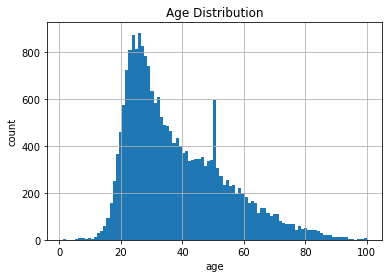

In [14]:
# Plot Age Distribution represented in the dataset
histogram_age = df['age'].hist(bins=df['age'].nunique())
plt.title('Age Distribution')
plt.xlabel('age')
plt.ylabel('count');

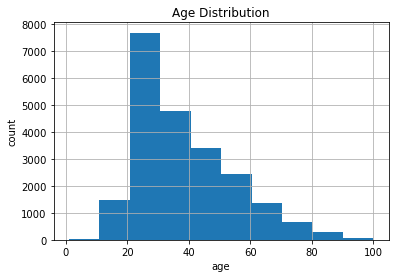

In [15]:
# Plot Age Distribution in ten (10) age bins
histogram_age = df['age'].hist(bins=10)
plt.title('Age Distribution')
plt.xlabel('age')
plt.ylabel('count');

***There seems to be an oddly overrepresented class around age 50. We will need to inspect further to figure out if this is a pre-processing issue that need to be fixed. ***

In [16]:
## Inspecting the odd value
hey = df.age.value_counts().sort_values(ascending=False)
#hey[:30]

In [17]:
df.head()

,dob,photo_taken,full_path,gender,age
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,28
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,60
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,41
5,716189,2012,[02/10002702_1960-11-09_2012.jpg],0.0,52
6,707745,1971,[41/10003541_1937-09-27_1971.jpg],1.0,34


In [21]:
# Create function to load images using 'load_img' and create array w shape(1, -1)
def getImagePixels(image_path):
    img = image.load_img("C:/Users/Prem/Desktop/SPRINGBOARD_MASTER/YOUNGER/Data/WIKI_CROP/%s" % image_path[0], grayscale=False, target_size=(224, 224))
    x = image.img_to_array(img).reshape(1, -1)[0]
    #x = preprocess_input(x)
    return x

In [22]:
# apply 'getImagePixels' function to all observations and create new column df.pixels
df['pixels'] = df['full_path'].apply(getImagePixels)

In [23]:
# spot check the 'apply' application of the function
df['pixels'][:5]

0    [255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255...
2    [92.0, 97.0, 91.0, 89.0, 94.0, 90.0, 91.0, 96....
4    [61.0, 30.0, 10.0, 61.0, 30.0, 10.0, 61.0, 30....
5    [97.0, 122.0, 178.0, 97.0, 122.0, 178.0, 97.0,...
6    [190.0, 189.0, 194.0, 204.0, 203.0, 208.0, 203...
Name: pixels, dtype: object

In [34]:
### Are there null values in the pixel column? ###
print("There are "+ str(df.pixels.isnull().sum())+ " null values in the pixel column")

There are 0 null values in the pixel column


In [39]:
# Export a '.csv' file of the dataframe
# This is a sensible place to pick up the project from for the next phases. 
# Applying the 'getImagePixels' function is time-consuming task and we don't want to run it again.
df.to_csv('out.csv', index=False)

# **IV. PREPROCESSING AND TRAINING**


# **V. MODELING**

# **VI. DOCUMENTATION**

# **VII. PRESENTATION**

# **VIII. REFERENCES**


1.   https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/ 
2.   https://data.vision.ee.ethz.ch/cvl/publications/papers/proceedings/eth_biwi_01229.pdf
3. https://sefiks.com/2019/02/13/apparent-age-and-gender-prediction-in-keras/ 

